### From Chapter 3 of Understanding Deep Learning Book

> Figure 3.3 shows the flow of computation that creates the function in figure 3.2a. Each hidden unit contains a linear function θ•0 + θ•1x of the input, and that line is clipped by the ReLU function a[•] below zero. **==The positions where the three lines cross zero become the three “joints” in the final output.==** The three clipped lines are then weighted by ϕ1, ϕ2, and ϕ3, respectively. Finally, the offset ϕ0 is added, which controls the overall height of the final function

### Figure 3.2
![figure](exercises/exer_screenshots/fig3132.png)

### Figure 3.3
![figure 3.3](exercises/exer_screenshots/fig3.3.png)

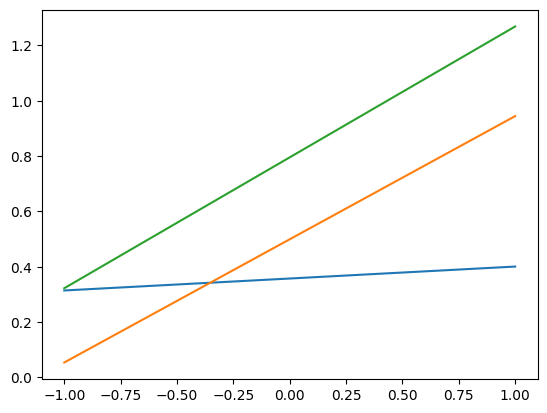

In [24]:
import numpy as np
import matplotlib.pyplot as plt

X = np.linspace(-1.0, 1.0, num=100).reshape(-1,1)
W = np.random.rand(3,1)
b = np.random.rand(1,3)

h = X @ W.T + b

plt.plot(X.reshape(-1), h[:,0].reshape(-1), label='w1*x + b')
plt.plot(X.reshape(-1), h[:,1].reshape(-1), label='w2*x + b')
plt.plot(X.reshape(-1), h[:,2].reshape(-1), label='w3*x + b')
plt.show()


### Added stuff
- Now let's add a training loop here to observe each linear regions

In [1]:
import jax.numpy as jnp
from jax import grad, jit, vmap, jacobian
from jax import random
from jaxlib.xla_extension import ArrayImpl
import math
from jax.scipy.special import logsumexp


# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-2):
  w_key, b_key = random.split(key)
  return scale * random.normal(w_key, (m, n)), scale * random.normal(b_key, (1, n))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(net_sizes, key):
  keys = random.split(key, len(net_sizes))
  return [
     random_layer_params(m, n, k) 
     for (m,n), k in zip(net_sizes, keys)
   ]

def display_params(params, params_name):
   print(f'{params_name} total num_layers = ', len(params))
   for level, param in enumerate(params, start=1):
      weight_shape = param[0].shape
      bias_shape = param[1].shape
      print(f'({level}) {params_name}_weights.shape = {weight_shape}, {params_name}_bias.shape = {bias_shape}')



In [2]:
def relu(x):
    return jnp.where(x >= 0, x, 0)

def mse(y_pred,y_target):
    return jnp.mean((y_pred - y_target) ** 2)

def linear(W, x):
    return x @ W

def predict(params, x_input):
    activations = x_input
    count = 0
    for w, b in params[:-1]:
        outputs = activations @ w + b
        activations = relu(outputs)
        print(count)
        count += 1
    
    final_w = params[-1][0]
    final_b = params[-1][1]

    logits = activations @ final_w + final_b
    return jnp.tanh(logits)

@jit
def loss_func(params, x_input, targets):
  preds = predict(params, x_input)
  return mse(preds, targets)

In [3]:
import numpy as np
import math

def generate_sine_data(num_samples):
  X = jnp.linspace(0, 2 * math.pi, num=num_samples).reshape(-1,1)
  y = jnp.sin(X)
  return X,y

def update_weights(params, x, y, learning_rate):
  grads = grad(loss_func)(params, x, y)
  return [(w - learning_rate * dw, b - learning_rate * db)
          for (w, b), (dw, db) in zip(params, grads)]

def train_network(params, num_samples, num_epochs, step_display):
  learning_rate = 0.01
  X,y = generate_sine_data(num_samples)

  for curr_epoch in range(1, num_epochs + 1):
    loss = loss_func(params, X, y)
    params = update_weights(params, X, y, learning_rate)
    if curr_epoch % step_display == 0:
      print(f'[{curr_epoch}/{num_epochs}] Loss: {loss}')

  return params

def parameter_sizes(params):
  layer_depth = len(params)
  for layer_num, layer in enumerate(params, start=1):
    weight_dims = layer[0].shape
    bias_dims = layer[1].shape
    print('weights_dtype = ', layer[0].dtype)
    print('bias_dtype = ', layer[1].dtype)

    print(f'[{layer_num}/{layer_depth}] weight_dims = {weight_dims}, bias_dims = {bias_dims}')


In [19]:
import matplotlib.pyplot as plt

def plot_first_activations(params, X, epoch_round):

    linear_01 = X @ params[0][0] + params[0][1]
    activation = relu(linear_01)
    linear_01 = np.array(linear_01)
    activation = np.array(activation)
    
    # linear_02 = activation @ params[1][0] + params[1][1]
    # output = jnp.tanh(linear_02)

    linear_columns = linear_01.shape[1]
    fig, axs = plt.subplots(2, linear_columns, figsize=(15,5))
    # y_min = jnp.min(linear_01)
    # y_max = jnp.max(linear_01)

    y_min = -2 
    y_max = 2
    X_flat = X.reshape(-1)

    for linear_col in range(linear_columns):
        axs[0, linear_col].plot(X_flat, linear_01[:, linear_col].reshape(-1))
        axs[0, linear_col].set_ylim([y_min, y_max])
        axs[0, linear_col].set_title(f'linear @ epoch_round={epoch_round}')
        axs[0, linear_col].set_xlabel('X')
        axs[0, linear_col].set_ylabel('linear_01')
        axs[0, linear_col].set_xlim([0, 2 * math.pi])

        axs[1, linear_col].plot(X_flat, activation[:, linear_col])
        axs[1, linear_col].set_ylim([y_min, y_max])
        axs[1, linear_col].set_title(f'linear @ at epoch_round={epoch_round}')
        axs[1, linear_col].set_xlabel('X')
        axs[1, linear_col].set_ylabel('linear_01')
        axs[1, linear_col].set_xlim([0, 2 * math.pi])

    
    fig.suptitle('Yeah')
    plt.show()

    




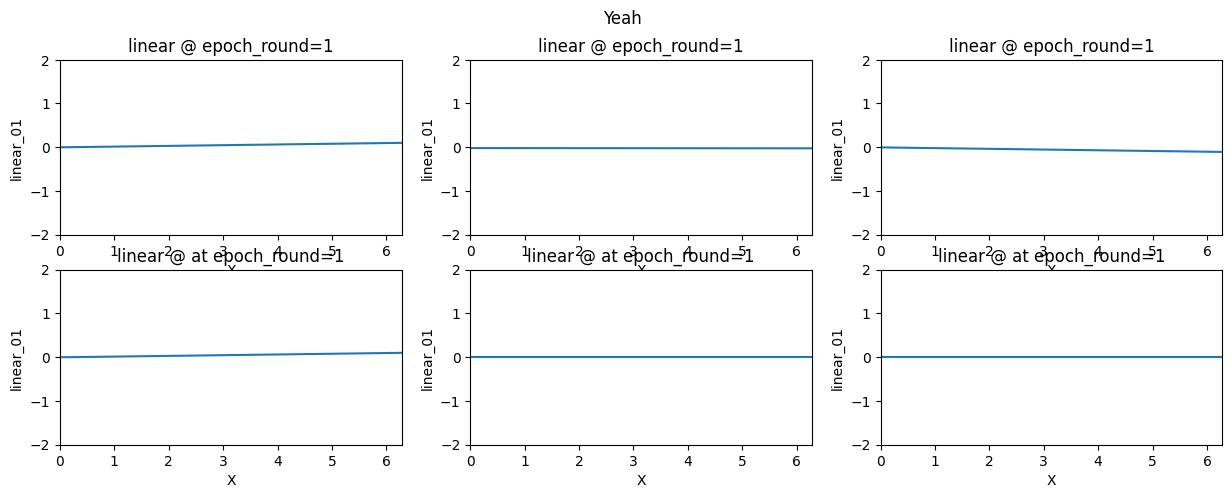

0
[10/1024] Loss: 0.49974048137664795
[20/1024] Loss: 0.49960964918136597
[30/1024] Loss: 0.49949803948402405
[40/1024] Loss: 0.49938616156578064
[50/1024] Loss: 0.49925532937049866
[60/1024] Loss: 0.4990842342376709
[70/1024] Loss: 0.4988456666469574
[80/1024] Loss: 0.49850237369537354
[90/1024] Loss: 0.4980013966560364
[100/1024] Loss: 0.4972672462463379
[110/1024] Loss: 0.49619218707084656
[120/1024] Loss: 0.494625061750412
[130/1024] Loss: 0.492358922958374
[140/1024] Loss: 0.48912182450294495
[150/1024] Loss: 0.48457929491996765
[160/1024] Loss: 0.47836267948150635
[170/1024] Loss: 0.47014120221138
[180/1024] Loss: 0.4597427546977997
[190/1024] Loss: 0.447287917137146
[200/1024] Loss: 0.43324464559555054
[210/1024] Loss: 0.4183143973350525
[220/1024] Loss: 0.40318763256073
[230/1024] Loss: 0.3883449137210846
[240/1024] Loss: 0.3740262985229492
[250/1024] Loss: 0.36031848192214966
[260/1024] Loss: 0.34724652767181396
[270/1024] Loss: 0.3348195552825928
[280/1024] Loss: 0.3230423629

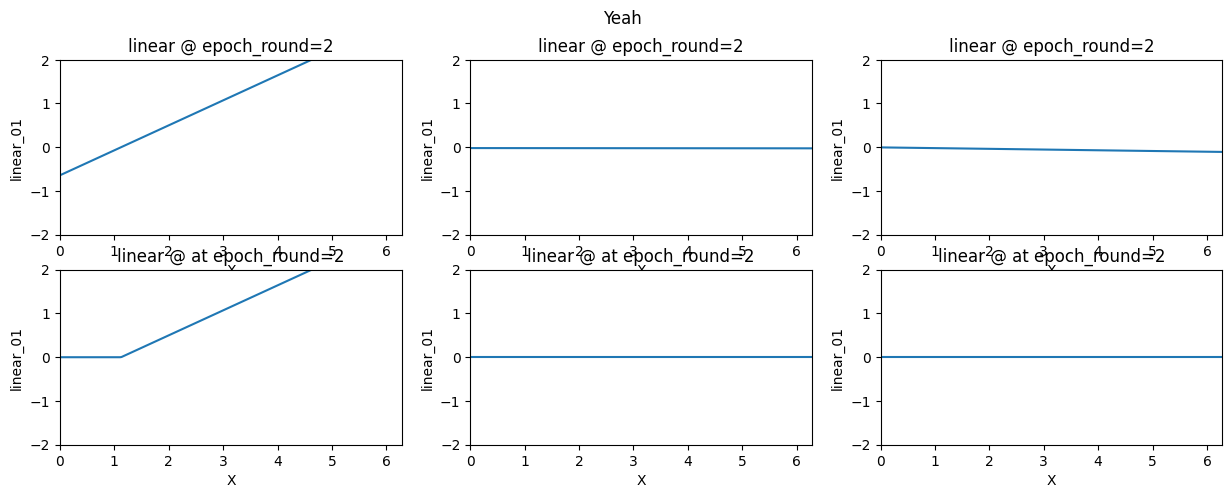

[10/1024] Loss: 0.12079864740371704
[20/1024] Loss: 0.12029269337654114
[30/1024] Loss: 0.11979737877845764
[40/1024] Loss: 0.11931239068508148
[50/1024] Loss: 0.11883772909641266
[60/1024] Loss: 0.11837277561426163
[70/1024] Loss: 0.1179172694683075
[80/1024] Loss: 0.11747093498706818
[90/1024] Loss: 0.11703366041183472
[100/1024] Loss: 0.11660505831241608
[110/1024] Loss: 0.11618485301733017
[120/1024] Loss: 0.11577285826206207
[130/1024] Loss: 0.11536877602338791
[140/1024] Loss: 0.11497257649898529
[150/1024] Loss: 0.11458393931388855
[160/1024] Loss: 0.1142025887966156
[170/1024] Loss: 0.11382834613323212
[180/1024] Loss: 0.11346101760864258
[190/1024] Loss: 0.11310051381587982
[200/1024] Loss: 0.11274661123752594
[210/1024] Loss: 0.11239922046661377
[220/1024] Loss: 0.11205801367759705
[230/1024] Loss: 0.11172295361757278
[240/1024] Loss: 0.11139383912086487
[250/1024] Loss: 0.11107055842876434
[260/1024] Loss: 0.1107528954744339
[270/1024] Loss: 0.11044079065322876
[280/1024] Lo

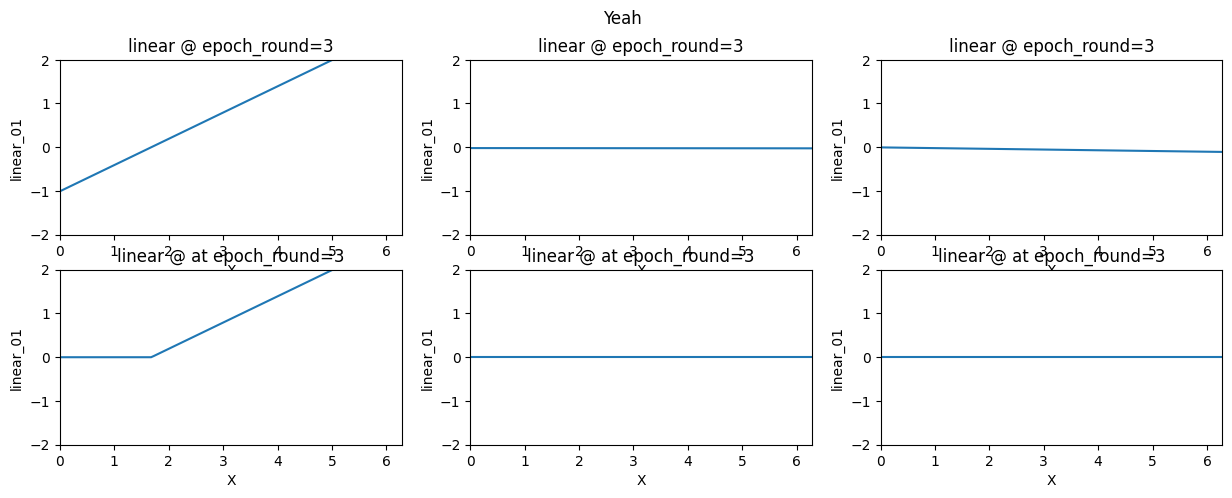

[10/1024] Loss: 0.09656768292188644
[20/1024] Loss: 0.09646622836589813
[30/1024] Loss: 0.09636572003364563
[40/1024] Loss: 0.09626683592796326
[50/1024] Loss: 0.0961688831448555
[60/1024] Loss: 0.09607231616973877
[70/1024] Loss: 0.09597685933113098
[80/1024] Loss: 0.0958825945854187
[90/1024] Loss: 0.09578955173492432
[100/1024] Loss: 0.09569750726222992
[110/1024] Loss: 0.09560677409172058
[120/1024] Loss: 0.09551692008972168
[130/1024] Loss: 0.0954284816980362
[140/1024] Loss: 0.09534074366092682
[150/1024] Loss: 0.09525448083877563
[160/1024] Loss: 0.09516885876655579
[170/1024] Loss: 0.09508465230464935
[180/1024] Loss: 0.09500112384557724
[190/1024] Loss: 0.09491893649101257
[200/1024] Loss: 0.09483739733695984
[210/1024] Loss: 0.09475715458393097
[220/1024] Loss: 0.09467752277851105
[230/1024] Loss: 0.09459920972585678
[240/1024] Loss: 0.09452146291732788
[250/1024] Loss: 0.09444502741098404
[260/1024] Loss: 0.09436912834644318
[270/1024] Loss: 0.0942944809794426
[280/1024] Los

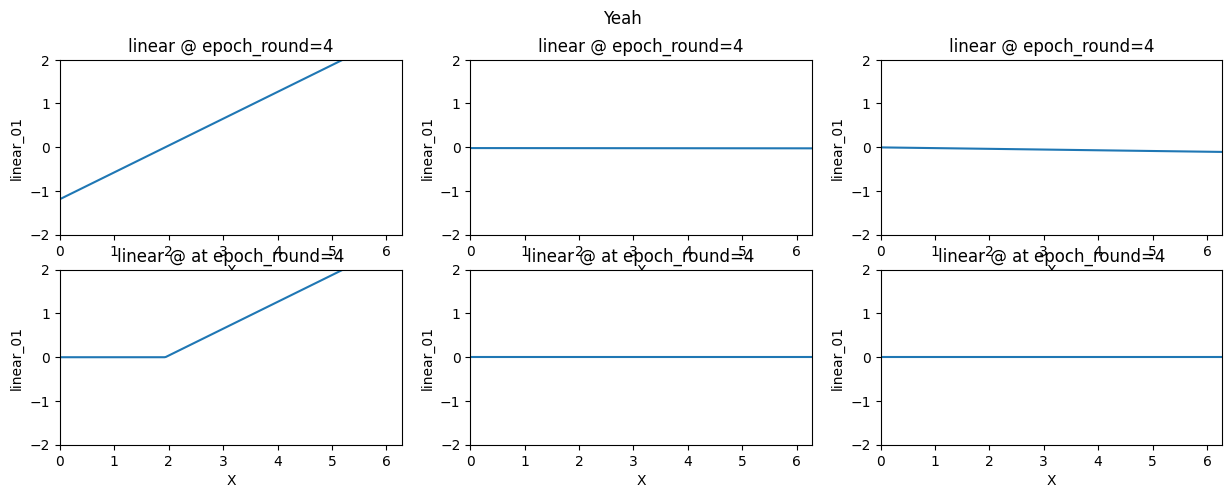

[10/1024] Loss: 0.09051118046045303
[20/1024] Loss: 0.0904797688126564
[30/1024] Loss: 0.09044874459505081
[40/1024] Loss: 0.09041818976402283
[50/1024] Loss: 0.09038783609867096
[60/1024] Loss: 0.09035768359899521
[70/1024] Loss: 0.09032808244228363
[80/1024] Loss: 0.09029876440763474
[90/1024] Loss: 0.09026964008808136
[100/1024] Loss: 0.09024073928594589
[110/1024] Loss: 0.09021241962909698
[120/1024] Loss: 0.090184286236763
[130/1024] Loss: 0.09015633165836334
[140/1024] Loss: 0.09012869745492935
[150/1024] Loss: 0.09010152518749237
[160/1024] Loss: 0.09007452428340912
[170/1024] Loss: 0.09004771709442139
[180/1024] Loss: 0.09002120792865753
[190/1024] Loss: 0.08999514579772949
[200/1024] Loss: 0.08996926248073578
[210/1024] Loss: 0.0899435430765152
[220/1024] Loss: 0.0899181216955185
[230/1024] Loss: 0.08989313989877701
[240/1024] Loss: 0.08986831456422806
[250/1024] Loss: 0.08984366059303284
[260/1024] Loss: 0.08981923758983612
[270/1024] Loss: 0.08979527652263641
[280/1024] Loss

In [22]:
# Network initial parameters
num_hidden = 3 
net_sizes = [
  (1, num_hidden),
  (num_hidden, 1),
]

random_seed = np.random.randint(0, 1024)
params = init_network_params(net_sizes, random.PRNGKey(random_seed))

current_epoch = 0
epoch_per_round = 1024
total_epoch_rounds = 5
num_training_samples = 1024
step_display = 10

for epoch_round in range(1, total_epoch_rounds):
    plot_first_activations(params, X_test, epoch_round)
    params = train_network(params, num_training_samples, epoch_per_round, step_display)
    X_test, y_test = generate_sine_data(256)
    # X_test, y_test = generate_sine_data(256)
    # y_pred = predict(params, X_test)
    # loss = loss_func(params, X_test, y_test)
    # print(f'[{epoch_round}]/{total_epoch_rounds} loss = {loss}')
    
     

In [40]:
X_test, y_test = generate_sine_data(512)



### Part 1
- Plot each linear component of initial layer.


### Sample Supblot Code

```python

import matplotlib.pyplot as plt


# Create a 1x3 subplot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plotting
# Plotting with y-axis limits set

y_min = np.min(y)
y_max = np.max(y)

axs[0].plot(X_flat, y[:, 0], color='green')
axs[0].set_ylim([y_min, y_max])
axs[0].set_title('y = b_00 + w_00 * x')
axs[0].set_xlabel('X input')
axs[0].set_ylabel('y')
axs[0].set_xlim([-1, 1])

axs[1].plot(X_flat, y[:, 1], color='gray')
axs[1].set_ylim([y_min, y_max])
axs[1].set_title('y = b_01 + w_01 * x')
axs[1].set_xlabel('X input')
axs[1].set_xlim([-1, 1])

axs[2].set_xlabel('X input')
axs[2].plot(X_flat, -(y[:, 0] + y[:, 1])/2, color='black')
axs[2].set_ylim([y_min, y_max])
axs[2].set_title('y = b_02 + w_02 * x')
axs[2].set_xlim([-1, 1])

# Display the plot
fig.suptitle('Sublinear Components of Shallow Networks')
plt.show()

```